In [ ]:
import os
import zipfile 
import gdown
import torch
from natsort import natsorted
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

## Setup
# Number of gpus available
ngpu = 1
device = torch.device('cuda:0' if (
    torch.cuda.is_available() and ngpu > 0) else 'cpu')

## Fetch data from Google Drive 
# Root directory for the dataset
data_root = 'data/celeba'
# Path to folder with the dataset
dataset_folder = f'{data_root}/img_align_celeba'
# URL for the CelebA dataset
url = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'
#url = 'https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view?usp=sharing&resourcekey=0-dYn9z10tMJOBAkviAcfdyQ'
# Path to download the dataset to
download_path = f'{data_root}/img_align_celeba.zip'

# Create required directories 
if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(dataset_folder)

# Download the dataset from google drive
gdown.download(url, download_path, quiet=False)

# Unzip the downloaded file 
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(dataset_folder)


Downloading...
From: https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:09<00:00, 155MB/s]


In [ ]:
filenames_list = []
dataset_dir = f'{data_root}/img_align_celeba/img_align_celeba/'

for filename in sorted(os.listdir(dataset_dir)):
    filenames_list.append(dataset_dir + filename)

filenames_list = filenames_list[:100000]
print(len(filenames_list))

100000


In [ ]:
filenames_list[0]

'data/celeba/img_align_celeba/img_align_celeba/000001.jpg'

In [ ]:
#Colourization class
import numpy as np
from tensorflow.keras.utils import Sequence

from skimage import io, color
from skimage.transform import resize
from matplotlib import pyplot as plt

img_size = 128

class Generator(Sequence):

    def __init__(self, filenames_list, batch_size, img_size):
        self.filenames_list = filenames_list
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return int(np.ceil(len(self.filenames_list) / float(self.batch_size)))

    def __getitem__(self, idx):

        batch_x = self.filenames_list[idx * self.batch_size:(idx + 1) * self.batch_size]

        input_tensor = np.empty((self.batch_size, self.img_size, self.img_size, 1), dtype=np.float32)
        output_tensor = np.empty((self.batch_size, self.img_size, self.img_size, 2), dtype=np.float32)

        i = 0
        for filename in batch_x:

            read_image = io.imread(filename)

            image = resize(read_image, (self.img_size, self.img_size), anti_aliasing=False, mode='constant')


            if image.shape == (self.img_size, self.img_size, 3) :
               try:
                    if not ((image[:, :, 0] == image[:, :, 1]).all()) \
                            or not ((image[:, :, 1] == image[:, :, 2]).all()):  # if not a BW image

                        image = color.rgb2lab(image)
                        # array image for output tensor
                        output_tensor[i, :] = (image[:, :, 1:] / 128)
                        # array values for input tensor
                        input_tensor[i, :] = (image[:, :, 0] / 100).reshape(img_size, img_size, 1)
                        i += 1
               except:
                    print(image.shape)
                    io.imshow(image)
                    plt.show()

        return input_tensor, output_tensor

In [ ]:
import os
import tensorflow as tf
import tensorflow.keras
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Input, ZeroPadding2D, Concatenate
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Root directory for the logs
log_root = f'{data_root}/logs'
# Path to folder with the dataset
weights_root = f'{data_root}//weights'

# Create required directories 
if not os.path.exists(log_root):
  os.makedirs(log_root)
  os.makedirs(weights_root)

In [ ]:
img_size = 128
batch_size = 64

training_batch_generator = Generator(filenames_list=filenames_list, batch_size=batch_size, img_size=img_size)

tensorboard = TensorBoard(log_dir=log_root+"/{}".format(time()))

# model

input_layer = Input(shape=(img_size, img_size, 1))

hidden_layer_1 = Conv2D(32, (7, 7), activation='relu', padding='same')(input_layer)
hidden_layer_1 = BatchNormalization()(hidden_layer_1)
hidden_layer_1 = Concatenate()([input_layer, hidden_layer_1])
hidden_layer_2 = Conv2D(64, (5, 5), activation='relu',  padding='same')(hidden_layer_1)
hidden_layer_2 = BatchNormalization()(hidden_layer_2)
hidden_layer_2 = Concatenate()([hidden_layer_1, hidden_layer_2])
hidden_layer_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(hidden_layer_2)
hidden_layer_3 = BatchNormalization()(hidden_layer_3)
hidden_layer_3 = Concatenate()([hidden_layer_2, hidden_layer_3])
hidden_layer_4 = Conv2D(64, (3, 3), activation='relu', padding='same')(hidden_layer_3)
hidden_layer_4 = BatchNormalization()(hidden_layer_4)
hidden_layer_4 = Concatenate()([hidden_layer_3, hidden_layer_4])
hidden_layer_5 = Conv2D(32, (3, 3), activation='relu', padding='same')(hidden_layer_4)
hidden_layer_5 = BatchNormalization()(hidden_layer_5)
hidden_layer_5 = Concatenate()([hidden_layer_4, hidden_layer_5])

output_layer = Conv2D(2, (3, 3), activation='tanh', padding='same')(hidden_layer_5)

model = Model(inputs=input_layer, outputs=output_layer)

opt = tensorflow.keras.optimizers.RMSprop()

model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
#plot_model(model, to_file='logs/rcnn/rcnn_model.png')
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  1600        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
1563/1563 [==============================] - 1084s 676ms/step - loss: 0.0246 - accuracy: 0.5868
Epoch 2/10
1563/1563 [==============================] - 1087s 692ms/step - loss: 0.0088 - accuracy: 0.6076
Epoch 3/10
1563/1563 [==============================] - 1066s 678ms/step - loss: 0.0086 - accuracy: 0.6101
Epoch 4/10
1563/1563 [==============================] - 1064s 677ms/step - loss: 0.0084 - accuracy: 0.6125
Epoch 5/10
1563/1563 [==============================] - 1059s 674ms/step - loss: 0.0080 - accuracy: 0.6183
Epoch 6/10
1563/1563 [==============================] - 1073s 679ms/step - loss: 0.0081 - accuracy: 0.6199
Epoch 7/10
1563/1563 [==============================] - 1060s 674ms/step - loss: 0.0080 - accuracy: 0.6206
Epoch 8/10
1563/1563 [==============================] - 1061s 675ms/step - loss: 0.0080 - accuracy: 0.6226
Epoch 9/10
1563/1563 [==============================] - 1059s 674ms/step - loss: 0.0079 - accuracy: 0.6219
Epoch 10/10
1563/1563 [==============

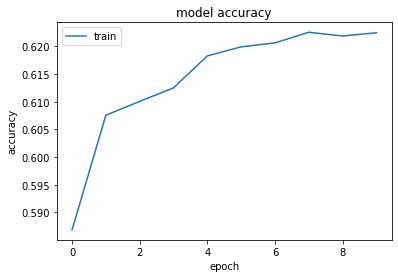

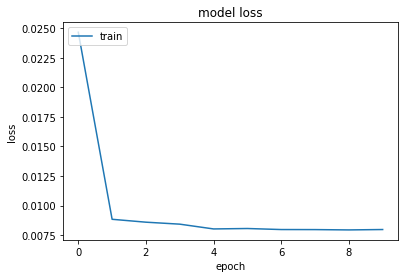

In [ ]:
with tf.device("/gpu:0"):
   history = model.fit_generator(training_batch_generator, epochs=10, verbose=1, use_multiprocessing=True,workers=8)
   #history = model.fit(training_batch_generator, epochs=10, verbose=1,workers=8)

   print(history.history.keys())
   # summarize history for accuracy
   plt.plot(history.history['accuracy'])
   plt.title('model accuracy')
   plt.ylabel('accuracy')
   plt.xlabel('epoch')
   plt.legend(['train', 'test'], loc='upper left')
   plt.savefig(log_root+"/accuracy_plot.png")
   plt.show()
   # summarize history for loss
   plt.plot(history.history['loss'])
   plt.title('model loss')
   plt.ylabel('loss')
   plt.xlabel('epoch')
   plt.legend(['train', 'test'], loc='upper left')
   plt.savefig(log_root+"/loss_plot.png")
   plt.show()

model.save(weights_root+"/RCNNs.h5")


In [ ]:
import numpy as np
import os
from keras.models import load_model
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.transform import resize
import pandas as pd


In [ ]:
img_size = 128
dataset_dir = f'{data_root}/img_align_celeba/img_align_celeba/'


def ret_input_output_tensor(dataset_dir, n_images):
    input_tensor = np.empty((n_images, img_size, img_size, 1))
    output_tensor = np.empty((n_images, img_size, img_size, 2))

    i = 0
    print(len(os.listdir(dataset_dir)))
    for filename in reversed(sorted(os.listdir(dataset_dir))):

        if filename.endswith('.jpg'):

            image = io.imread(dataset_dir + filename)
            image = resize(image, (img_size, img_size, 3), anti_aliasing=False, mode='constant')
            image = color.rgb2lab(image)

            if image.shape == (img_size, img_size, 3):  # if not a BW image
                # array image for output tensor
                output_tensor[i, :] = (image[:, :, 1:] / 128)
                # array values for input tensor
                input_tensor[i, :] = (image[:, :, 0] / 100).reshape(img_size, img_size, 1)
                i += 1

        if i >= n_images: break

    return input_tensor, output_tensor


In [ ]:
print(os.listdir())
model = load_model("/content/data/RCNNs.h5")

# prediction

input_tensor, output_tensor = ret_input_output_tensor(dataset_dir, 10)

prediction = model.predict(input_tensor)

['.config', 'data', 'sample_data']
202599


input tensor :
 (128, 128, 1)
prediction :
 [[[ 0.02479268  0.00586888]
  [ 0.02294688  0.02972092]
  [ 0.00380456  0.01494315]
  ...
  [ 0.00494672  0.01554723]
  [ 0.01178028 -0.00289173]
  [ 0.01379561  0.02186326]]

 [[ 0.00239574  0.00942954]
  [-0.00170242  0.00296315]
  [ 0.00177211  0.01113249]
  ...
  [ 0.00246339  0.01090446]
  [ 0.00883613  0.00883082]
  [ 0.00968144  0.01592497]]

 [[ 0.00372412  0.01441577]
  [ 0.00140496  0.01251843]
  [ 0.00130593  0.013276  ]
  ...
  [ 0.00332028  0.01254999]
  [ 0.00763977  0.01313386]
  [ 0.00731724  0.01029836]]

 ...

 [[ 0.00304853  0.01172661]
  [ 0.00203901  0.01104285]
  [ 0.005108    0.01104929]
  ...
  [ 0.18166448  0.14870091]
  [ 0.17705265  0.15960465]
  [ 0.15081945  0.15238991]]

 [[ 0.01540592  0.01130637]
  [ 0.00762552  0.01034673]
  [ 0.00701361  0.00438425]
  ...
  [ 0.16141707  0.13333555]
  [ 0.15239671  0.13836065]
  [ 0.12298218  0.1238572 ]]

 [[ 0.0246886   0.02263285]
  [-0.00221894  0.00861036]
  [ 0.00831773

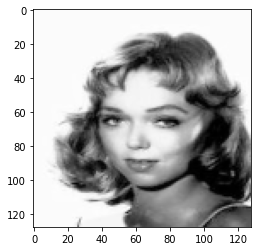

(128, 128, 3)


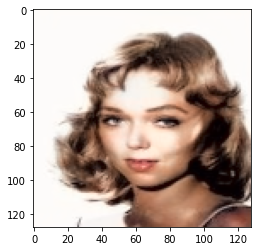

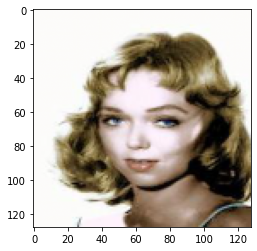

input tensor :
 (128, 128, 1)
prediction :
 [[[ 0.06056695  0.02043369]
  [ 0.07259154  0.04217578]
  [ 0.06454466  0.02854124]
  ...
  [ 0.03932566  0.06558326]
  [ 0.04640998  0.03902541]
  [ 0.04332035  0.05492825]]

 [[ 0.05690831  0.04203341]
  [ 0.06429397  0.03203248]
  [ 0.07620997  0.03623749]
  ...
  [ 0.04595636  0.06157919]
  [ 0.05312091  0.05760976]
  [ 0.05010318  0.06107251]]

 [[ 0.0668277   0.05307788]
  [ 0.0777702   0.05005134]
  [ 0.09013161  0.04855894]
  ...
  [ 0.04947362  0.06598544]
  [ 0.05260601  0.06523816]
  [ 0.05228188  0.06721981]]

 ...

 [[ 0.04024474  0.03165532]
  [ 0.04489156  0.02959172]
  [ 0.05172274  0.03372075]
  ...
  [ 0.02062585 -0.00285337]
  [ 0.01871371 -0.00122451]
  [ 0.0159188  -0.00321121]]

 [[ 0.04576189  0.02849933]
  [ 0.04459922  0.02918318]
  [ 0.05017299  0.02617103]
  ...
  [ 0.01902347 -0.00678264]
  [ 0.01150406 -0.00031216]
  [ 0.00417169 -0.00903895]]

 [[ 0.04872862  0.03770521]
  [ 0.02976409  0.02715151]
  [ 0.04798402

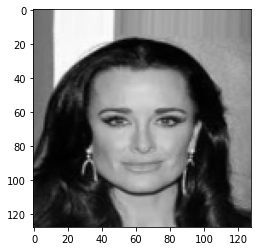

(128, 128, 3)


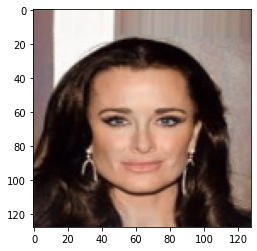

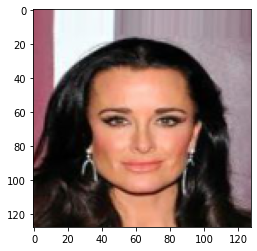

input tensor :
 (128, 128, 1)
prediction :
 [[[ 0.04861535  0.03474845]
  [ 0.0532745   0.06031287]
  [ 0.03933039  0.05014394]
  ...
  [ 0.05745295  0.0549875 ]
  [ 0.06167731  0.03224627]
  [ 0.05275365  0.04860117]]

 [[ 0.03593801  0.04901008]
  [ 0.03673311  0.04400406]
  [ 0.04299187  0.05097105]
  ...
  [ 0.06270485  0.049464  ]
  [ 0.06701015  0.0485967 ]
  [ 0.05884884  0.05037027]]

 [[ 0.04320396  0.0605484 ]
  [ 0.04539341  0.06070812]
  [ 0.05038042  0.06020882]
  ...
  [ 0.06454311  0.0510569 ]
  [ 0.0658845   0.05084223]
  [ 0.06168468  0.05028179]]

 ...

 [[ 0.02453823  0.00334035]
  [ 0.02737026 -0.00413161]
  [ 0.03367549 -0.00094382]
  ...
  [ 0.05574083  0.01544674]
  [ 0.05348391  0.02168502]
  [ 0.04790952  0.03300981]]

 [[ 0.03234025  0.00403698]
  [ 0.02833038 -0.00411579]
  [ 0.03136557 -0.00867095]
  ...
  [ 0.04818427  0.00421234]
  [ 0.04071217  0.01416658]
  [ 0.03051199  0.01558201]]

 [[ 0.03997156  0.0200236 ]
  [ 0.01665704 -0.00034127]
  [ 0.03008532

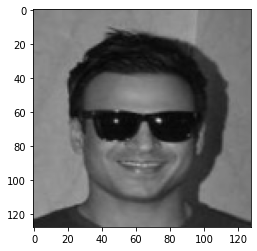

(128, 128, 3)


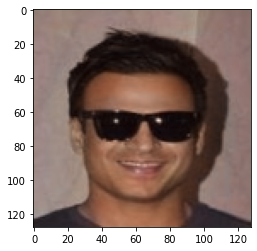

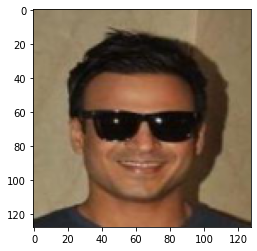

input tensor :
 (128, 128, 1)
prediction :
 [[[ 0.03666122 -0.01324568]
  [ 0.03946644  0.00836714]
  [ 0.02490632  0.00231982]
  ...
  [ 0.01734658  0.05169526]
  [ 0.02508412  0.02578008]
  [ 0.02551209  0.04586857]]

 [[ 0.02253503  0.00654352]
  [ 0.02212593 -0.00107601]
  [ 0.02607302  0.00603576]
  ...
  [ 0.01808796  0.05099816]
  [ 0.02673421  0.04465806]
  [ 0.02905299  0.05124665]]

 [[ 0.02261011  0.00545214]
  [ 0.02716454  0.00165271]
  [ 0.03129185  0.00631261]
  ...
  [ 0.01252465  0.05030182]
  [ 0.01854298  0.04557656]
  [ 0.02478503  0.05316358]]

 ...

 [[ 0.05668856  0.05095751]
  [ 0.05727585  0.04726537]
  [ 0.05187965  0.05427296]
  ...
  [ 0.04565115  0.00758189]
  [ 0.04584333  0.01338226]
  [ 0.04204115  0.01640017]]

 [[ 0.05983208  0.05700711]
  [ 0.05393823  0.06198476]
  [ 0.04774948  0.05485404]
  ...
  [ 0.0423174   0.00102515]
  [ 0.03531962  0.01020757]
  [ 0.02613399  0.00766113]]

 [[ 0.05654147  0.06222685]
  [ 0.03934863  0.05789313]
  [ 0.05211379

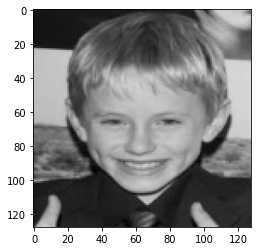

(128, 128, 3)


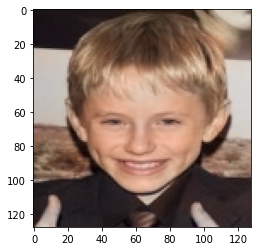

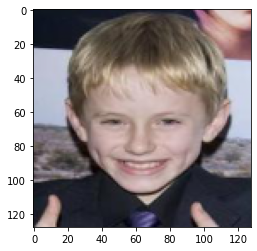

input tensor :
 (128, 128, 1)
prediction :
 [[[ 0.02758419  0.01589832]
  [ 0.02514863  0.04076716]
  [ 0.00544123  0.02551429]
  ...
  [ 0.00766729  0.02673455]
  [ 0.01396735  0.00485077]
  [ 0.0159512   0.02779163]]

 [[ 0.00435105  0.01914821]
  [-0.00146564  0.01301124]
  [-0.00122217  0.01893348]
  ...
  [ 0.00449645  0.01938322]
  [ 0.0116622   0.01623883]
  [ 0.01406331  0.02423953]]

 [[ 0.00834843  0.02557363]
  [ 0.00246089  0.02471278]
  [-0.00136876  0.02370336]
  ...
  [ 0.00258749  0.01956569]
  [ 0.00816192  0.01884893]
  [ 0.00984593  0.01892533]]

 ...

 [[ 0.01941525  0.03515338]
  [ 0.01796976  0.03451291]
  [ 0.02033574  0.0359927 ]
  ...
  [ 0.04864779  0.11384991]
  [ 0.05005992  0.1076657 ]
  [ 0.0408119   0.09703682]]

 [[ 0.02840474  0.03923633]
  [ 0.01840683  0.03900104]
  [ 0.02041979  0.0346806 ]
  ...
  [ 0.05478001  0.11130948]
  [ 0.04896314  0.10600197]
  [ 0.03822138  0.07959405]]

 [[ 0.03587592  0.04894436]
  [ 0.01394607  0.0399645 ]
  [ 0.0338828 

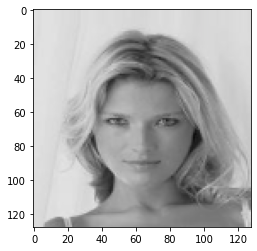

(128, 128, 3)


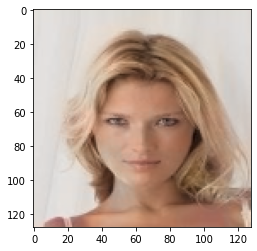

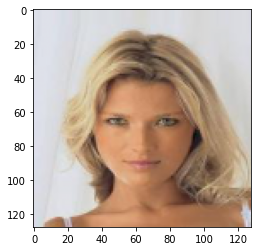

input tensor :
 (128, 128, 1)
prediction :
 [[[0.03486625 0.0319916 ]
  [0.03349052 0.05812931]
  [0.01522368 0.04433279]
  ...
  [0.02014341 0.02410081]
  [0.02281534 0.00687674]
  [0.02196083 0.0319096 ]]

 [[0.01612414 0.03960891]
  [0.0112147  0.03476691]
  [0.01308923 0.04017185]
  ...
  [0.01411655 0.02069245]
  [0.01607568 0.01875623]
  [0.01861129 0.02660667]]

 [[0.02137188 0.05005599]
  [0.01618819 0.05073408]
  [0.01513707 0.04708085]
  ...
  [0.00768157 0.02177346]
  [0.01037098 0.02286101]
  [0.01569365 0.02547358]]

 ...

 [[0.12935825 0.13468324]
  [0.13848703 0.14844164]
  [0.13675515 0.15072717]
  ...
  [0.00816454 0.00970213]
  [0.01192217 0.01477709]
  [0.01011054 0.00937535]]

 [[0.11269371 0.12727633]
  [0.12070339 0.1421385 ]
  [0.1284557  0.14823787]
  ...
  [0.01068584 0.00321876]
  [0.00675786 0.01195925]
  [0.00307661 0.001421  ]]

 [[0.09495561 0.11768866]
  [0.09101494 0.1343705 ]
  [0.12559986 0.15859693]
  ...
  [0.01100897 0.0018941 ]
  [0.00996852 0.0156

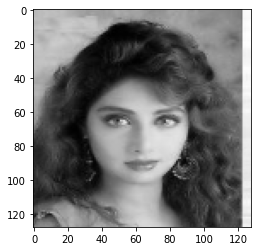

(128, 128, 3)


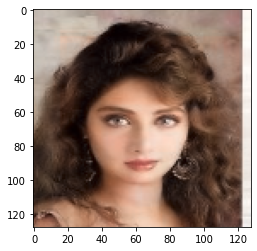

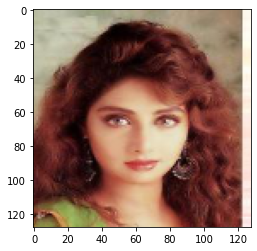

input tensor :
 (128, 128, 1)
prediction :
 [[[ 2.5813812e-02  9.8972358e-03]
  [ 2.3617374e-02  3.3928182e-02]
  [ 3.7375810e-03  1.8067515e-02]
  ...
  [ 5.0846227e-03  1.6638361e-02]
  [ 1.1690619e-02 -2.2860351e-03]
  [ 1.3851266e-02  2.2443777e-02]]

 [[ 2.6358564e-03  1.2344645e-02]
  [-2.1666735e-03  5.7467362e-03]
  [-9.1865659e-05  1.2664867e-02]
  ...
  [ 2.3597023e-03  1.1330388e-02]
  [ 8.9774011e-03  9.3335249e-03]
  [ 9.9496786e-03  1.6770618e-02]]

 [[ 5.3297929e-03  1.7777305e-02]
  [ 1.8557176e-03  1.6006975e-02]
  [-3.8173422e-04  1.5332201e-02]
  ...
  [ 2.9944014e-03  1.3059229e-02]
  [ 7.5197886e-03  1.3551864e-02]
  [ 7.3240763e-03  1.1111583e-02]]

 ...

 [[ 2.3554616e-02 -2.4614483e-04]
  [ 2.8639007e-02 -7.3952889e-03]
  [ 3.1210801e-02 -1.0783667e-03]
  ...
  [ 9.3194567e-02  1.2210357e-02]
  [ 7.9813123e-02  1.5933780e-02]
  [ 6.6280551e-02  1.6556632e-02]]

 [[ 3.4407422e-02  2.4250895e-04]
  [ 3.2002054e-02 -7.4637332e-03]
  [ 3.2831039e-02 -1.0492766e-02]


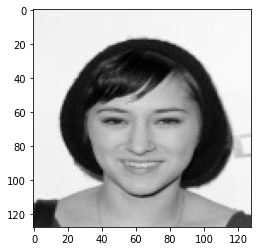

(128, 128, 3)


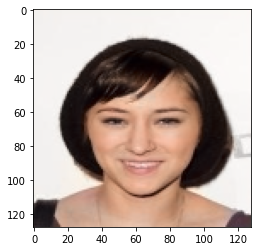

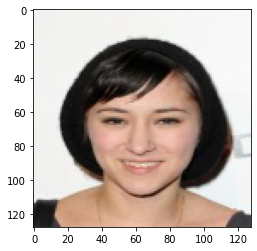

input tensor :
 (128, 128, 1)
prediction :
 [[[ 0.04987668  0.05064262]
  [ 0.05443857  0.07984149]
  [ 0.0385449   0.07642379]
  ...
  [ 0.03384379  0.00674565]
  [ 0.03868966 -0.00797872]
  [ 0.0328516   0.01779684]]

 [[ 0.03662184  0.06734422]
  [ 0.03756217  0.06371766]
  [ 0.04237079  0.07432246]
  ...
  [ 0.03230096  0.00592489]
  [ 0.02900299  0.00097833]
  [ 0.02570531  0.00401625]]

 [[ 0.04071559  0.08398174]
  [ 0.04140623  0.08256453]
  [ 0.04619799  0.08318897]
  ...
  [ 0.03499552  0.00270582]
  [ 0.03262216  0.00077764]
  [ 0.02930825 -0.00151781]]

 ...

 [[ 0.09419814  0.14214356]
  [ 0.0910316   0.1560744 ]
  [ 0.07161108  0.15195993]
  ...
  [ 0.07976223  0.07339796]
  [ 0.07239155  0.06396841]
  [ 0.06311233  0.06368964]]

 [[ 0.08489733  0.13428304]
  [ 0.08384223  0.1489666 ]
  [ 0.06993908  0.14900753]
  ...
  [ 0.07545902  0.06130116]
  [ 0.05799159  0.05493338]
  [ 0.04617425  0.04683873]]

 [[ 0.07640642  0.12195191]
  [ 0.06374572  0.13558239]
  [ 0.08213706

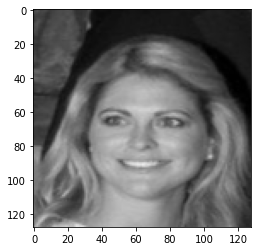

(128, 128, 3)


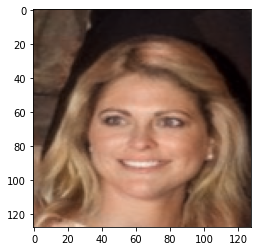

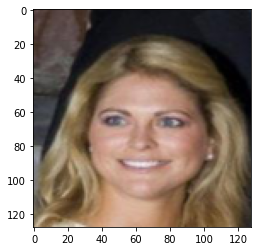

input tensor :
 (128, 128, 1)
prediction :
 [[[ 0.02695643  0.01435708]
  [ 0.02467934  0.03878157]
  [ 0.00486921  0.02270727]
  ...
  [ 0.00624844  0.02239623]
  [ 0.01180995  0.0011244 ]
  [ 0.01445253  0.02528902]]

 [[ 0.00372346  0.01664133]
  [-0.00206443  0.01002272]
  [-0.00119593  0.01593365]
  ...
  [ 0.00218354  0.01407491]
  [ 0.00918303  0.01192442]
  [ 0.0112933   0.02062252]]

 [[ 0.0074948   0.02318325]
  [ 0.00214436  0.02171328]
  [-0.00113674  0.0204948 ]
  ...
  [ 0.00104836  0.01551167]
  [ 0.00623518  0.0154081 ]
  [ 0.00728312  0.01479346]]

 ...

 [[ 0.00648342  0.02513099]
  [ 0.00472941  0.02515598]
  [ 0.0081596   0.02575523]
  ...
  [ 0.02011967  0.03248955]
  [ 0.0207881   0.03057212]
  [ 0.02182484  0.03582674]]

 [[ 0.01905407  0.02804202]
  [ 0.00936795  0.02972   ]
  [ 0.00980377  0.02342905]
  ...
  [ 0.02129264  0.0249418 ]
  [ 0.01481125  0.02804954]
  [ 0.01613262  0.02631781]]

 [[ 0.02555363  0.03662013]
  [-0.00072508  0.02735244]
  [ 0.0130012 

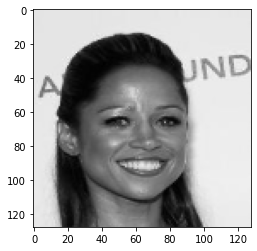

(128, 128, 3)


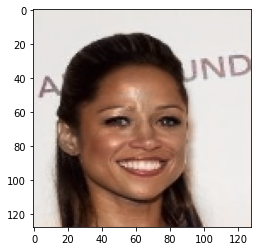

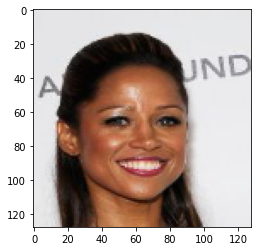

input tensor :
 (128, 128, 1)
prediction :
 [[[ 0.03401221 -0.01670937]
  [ 0.0371897   0.00542416]
  [ 0.02303612  0.00012136]
  ...
  [ 0.02231451  0.00418054]
  [ 0.02556881 -0.01230666]
  [ 0.02285642  0.01424192]]

 [[ 0.01965101  0.00278928]
  [ 0.01967905 -0.00411504]
  [ 0.02367126  0.00320553]
  ...
  [ 0.01946716  0.00410226]
  [ 0.01753957 -0.00060561]
  [ 0.01429106  0.00222411]]

 [[ 0.01835596  0.00078843]
  [ 0.02368538 -0.00293095]
  [ 0.02902062  0.00211604]
  ...
  [ 0.02130833  0.00180234]
  [ 0.01916848 -0.00018931]
  [ 0.01655583 -0.00272308]]

 ...

 [[ 0.03317418  0.01095183]
  [ 0.04234384  0.00877491]
  [ 0.04975402  0.01422744]
  ...
  [ 0.05326996  0.03162162]
  [ 0.04787616  0.03071171]
  [ 0.04816183  0.04175208]]

 [[ 0.03934399  0.01256813]
  [ 0.04084572  0.00927994]
  [ 0.04537699  0.00519659]
  ...
  [ 0.05653983  0.04072925]
  [ 0.04536084  0.03721657]
  [ 0.0390302   0.04045878]]

 [[ 0.04306133  0.0260164 ]
  [ 0.02502891  0.01009665]
  [ 0.0413365 

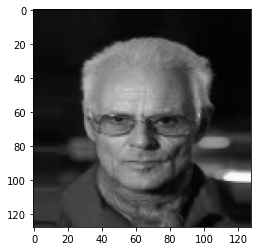

(128, 128, 3)


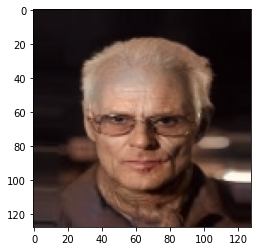

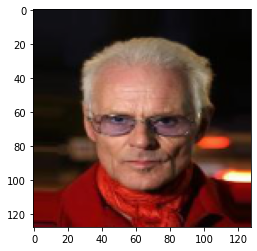

(10, 128, 128, 2)
                0             1    ...         126         127
count  1.280000e+02  1.280000e+02  ...  128.000000  128.000000
mean  -2.748456e-03 -2.748456e-03  ...    0.005724    0.004824
std    2.176925e-18  2.176925e-18  ...    0.021451    0.021632
min   -2.748456e-03 -2.748456e-03  ...   -0.030263   -0.023305
25%   -2.748456e-03 -2.748456e-03  ...   -0.004083   -0.002748
50%   -2.748456e-03 -2.748456e-03  ...   -0.002748   -0.002748
75%   -2.748456e-03 -2.748456e-03  ...    0.007304    0.002564
max   -2.748456e-03 -2.748456e-03  ...    0.073751    0.078653

[8 rows x 128 columns]
              0           1           2    ...         125         126         127
count  128.000000  128.000000  128.000000  ...  128.000000  128.000000  128.000000
mean     0.002772    0.001572    0.003557  ...    0.032971    0.036478    0.031912
std      0.003039    0.002054    0.000692  ...    0.044991    0.043980    0.037907
min      0.000912   -0.002219    0.001306  ...   -0.004111 

In [ ]:
for i in range(10):
    print("input tensor :\n", input_tensor[i].shape)
    print("prediction :\n", prediction[i])
    print("output tensor :\n", output_tensor[i])

    input_image = np.concatenate((input_tensor[i], np.zeros((img_size, img_size, 2))), axis=2)
    input_image[:, :, 0] = input_image[:, :, 0] * 100
    input_image = color.lab2rgb(input_image)
    print(input_image.shape)
    plt.imshow(input_image, cmap='gray')
    plt.show()
    plt.imsave('/content/data/log/'+str(i)+'_input.png', input_image)

    output_image = np.concatenate((input_tensor[i], prediction[i]), axis=2)
    output_image[:, :, 0] = output_image[:, :, 0] * 100
    output_image[:, :, 1:] = (output_image[:, :, 1:]) * 128
    output_image = color.lab2rgb(output_image)
    print(output_image.shape)

    plt.imshow(output_image)
    plt.show()
    plt.imsave('/content/data/log/' + str(i) + '_prediction.png', output_image)

    output_image = np.concatenate((input_tensor[i], output_tensor[i]), axis=2)
    output_image[:, :, 0] = output_image[:, :, 0] * 100
    output_image[:, :, 1:] = (output_image[:, :, 1:] ) * 128

    output_image = color.lab2rgb(output_image)
    plt.imshow(output_image)
    plt.show()
    plt.imsave('/content/data//log/' + str(i) + '_actual.png', output_image)

print(prediction.shape)
print(pd.DataFrame(data=output_tensor[0,:,:,0]).describe())
print(pd.DataFrame(data=prediction[0,:,:,0]).describe())


In [ ]:
!zip -r /content/data/log.zip /content/data/log

  adding: content/data/log/ (stored 0%)
  adding: content/data/log/8_input.png (deflated 2%)
  adding: content/data/log/3_input.png (deflated 3%)
  adding: content/data/log/2_actual.png (stored 0%)
  adding: content/data/log/0_input.png (deflated 3%)
  adding: content/data/log/4_prediction.png (deflated 0%)
  adding: content/data/log/5_input.png (deflated 2%)
  adding: content/data/log/7_input.png (deflated 1%)
  adding: content/data/log/7_actual.png (stored 0%)
  adding: content/data/log/8_prediction.png (stored 0%)
  adding: content/data/log/9_prediction.png (stored 0%)
  adding: content/data/log/2_prediction.png (stored 0%)
  adding: content/data/log/1_actual.png (stored 0%)
  adding: content/data/log/8_actual.png (deflated 0%)
  adding: content/data/log/5_prediction.png (deflated 0%)
  adding: content/data/log/3_prediction.png (deflated 0%)
  adding: content/data/log/6_prediction.png (stored 0%)
  adding: content/data/log/0_prediction.png (stored 0%)
  adding: content/data/log/9_in